In [1]:
import os
import sys
import glob as glob
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import seaborn as sb
import healpy
import numpy as np
import desispec.io
import fitsio
%matplotlib inline
sb.set_style('white')

In [2]:
#A simple filter was added to retain some of the noise and check this is reproduced,
#but still be able to spot differences due to features by eye. 
#Plotspec routine was taken https://github.com/desihub/tutorials/blob/master/Intro_to_DESI_spectra.ipynb. 
#It allows to add the true spectra although we will not use this option here 
#These plots will show the three arms of the spectrograph in colors blue ['b'], red ['r'] and yellow ['z'].


def plotspec(spectra, i, truewave=None, trueflux=None, color=['b','r','y'],nfilter=1,label=None):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), color=color[0], alpha=0.5,label=label)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), color=color[1], alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), color=color[2], alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymax = np.max(spectra.flux['b'][i])
    ymin=0
        
    plt.ylim(ymin, ymax+3)
    plt.ylabel('Flux')
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    return
    
#This will compare two spectra by dividing the first over the second
def plotspec_ratio(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]/spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]/spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]/spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This will compare two spectra by substracting the second from the first one
def plotspec_diff(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]-spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]-spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]-spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    if label!=None:
        plt.legend(loc='best')

#This is only to compute the observed wavelenght of given line that corresponds to the quasar redshift. e.g 

def draw_obsline(lbda,z):
    return (1.+z)*lbda

## parameters needed to run a quickquasars simulation

In [3]:
!quickquasars --help

INFO:utils.py:79:freeze_iers: Freezing IERS table used by astropy time, coordinates.
usage: quickquasars [-h] -i [INFILE [INFILE ...]] [-o OUTFILE]
                    [--outdir OUTDIR] [--program PROGRAM] [--seeing SEEING]
                    [--airmass AIRMASS] [--exptime EXPTIME]
                    [--moonfrac MOONFRAC] [--moonalt MOONALT]
                    [--moonsep MOONSEP] [--seed SEED] [--skyerr SKYERR]
                    [--downsampling DOWNSAMPLING] [--zmin ZMIN] [--zmax ZMAX]
                    [--wmin WMIN] [--wmax WMAX] [--dwave DWAVE] [--zbest]
                    [--sigma_kms_fog SIGMA_KMS_FOG]
                    [--gamma_kms_zfit [GAMMA_KMS_ZFIT]]
                    [--shift_kms_los SHIFT_KMS_LOS] [--target-selection]
                    [--mags] [--bbflux] [--add-LYB]
                    [--metals [METALS [METALS ...]]]
                    [--metals-from-file [METALS_FROM_FILE]] [--dla DLA]
                    [--balprob BALPROB] [--no-simqso] [--desi-footprint]

In [4]:
zmin = 1.8 # We use to add it, although it is already set as minimum in the transmission files.
nmax = 10 # maximun number of spectra to simulate in a given pixel, chosen as a small number for speedness in this tutorial.
seed=123 #this ensure reproducibility

In [5]:
path_mocks = '/global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0' # path to london mocks v9.0
ifile=path_mocks + '/v9.0.0/0/0/transmission-16-0.fits.gz'   #Choose one pixel to simulate the quasars. 
outdir=os.path.join(os.environ['SCRATCH'], 'mocks','quickquasar','1pix_test/')  #Where do you want to save the files.
print(outdir) #Adjuts the path if this is not where you want to store the files produced by this tutorial

/global/cscratch1/sd/tanting/mocks/quickquasar/1pix_test/


In [6]:
os.makedirs(outdir, exist_ok=True)

In [7]:
#Run quickquasars for the different exposures, store each run a different directory to avoid overwrting.
exposures = ['1','2','3','4','1e5']
contaminant='0.0-' # Following somehow the convention in https://desi.lbl.gov/trac/wiki/LymanAlphaWG/LondonMocks/v9_quickquasars

for exp in exposures:
    if not os.path.exists(outdir +contaminant+exp):
        os.mkdir(outdir +contaminant+exp )
    specfile = outdir +contaminant+exp+'/spectra.fits'
    cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
    --nmax {nmax} --seed {seed}'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
    !time $cmd

INFO:utils.py:79:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:quickquasars.py:817:main: Load SIMQSO model
INFO:quickquasars.py:825:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:210:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:215:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:223:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:302:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:306:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:quickquasars.py:311:simulate_one_healpix: Add FOG to redshi

## comapare the spectra we got from each simulation

In [8]:
dump = []
for exp in exposures:
    dump.append(outdir +'0.0-'+exp)
path_highexp = dump[-1]
del(dump[-1])
dump.sort()
print(path_highexp)

/global/cscratch1/sd/tanting/mocks/quickquasar/1pix_test/0.0-1e5


In [9]:
spec = fitsio.FITS(path_highexp+'/spectra.fits')
spec


  file: /global/cscratch1/sd/tanting/mocks/quickquasar/1pix_test/0.0-1e5/spectra.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      IMAGE_HDU       B_WAVELENGTH
  3      IMAGE_HDU       B_FLUX
  4      IMAGE_HDU       B_IVAR
  5      IMAGE_HDU       B_MASK
  6      IMAGE_HDU       B_RESOLUTION
  7      IMAGE_HDU       R_WAVELENGTH
  8      IMAGE_HDU       R_FLUX
  9      IMAGE_HDU       R_IVAR
  10     IMAGE_HDU       R_MASK
  11     IMAGE_HDU       R_RESOLUTION
  12     IMAGE_HDU       Z_WAVELENGTH
  13     IMAGE_HDU       Z_FLUX
  14     IMAGE_HDU       Z_IVAR
  15     IMAGE_HDU       Z_MASK
  16     IMAGE_HDU       Z_RESOLUTION

In [10]:
truth = fitsio.FITS(path_highexp + '/truth-16-0.fits')

In [12]:
spectra_highexp = desispec.io.read_spectra(path_highexp+'/spectra.fits')

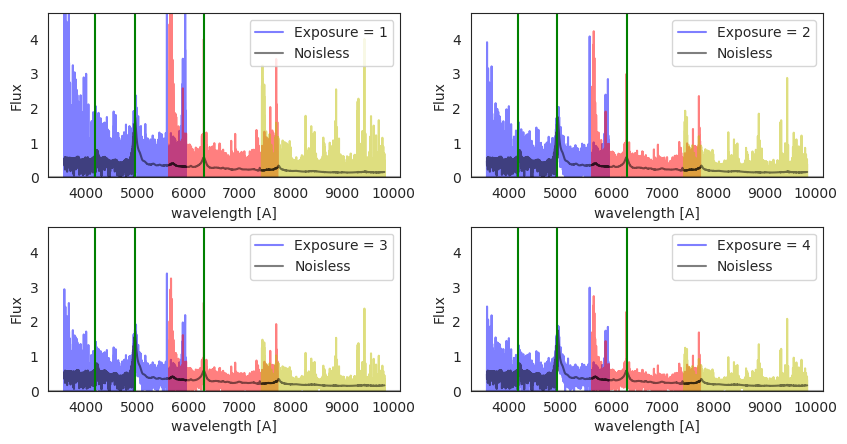

In [13]:
index = 4
plt.figure(figsize=(10,5),dpi=100)
for i in range(len(dump)):
    plt.subplot(221+i)
    exposure = dump[i].split('/0.0-')[-1]
    spectra= desispec.io.read_spectra(dump[i]+'/spectra.fits')
    plotspec(spectra,index,label='Exposure = '+exposure)
    plotspec(spectra_highexp,index,color=['k','k','k'],label='Noisless')
    z_obj = truth[1]['Z'][index]
    lya = draw_obsline(1215.67,z_obj)
    lyb = draw_obsline(1025.722,z_obj)
    civ = draw_obsline(1549.48,z_obj)
    #mgii = draw_obsline(2799.117,z_obj)
    plt.axvline(lya,color='g')
    plt.axvline(lyb,color='g')
    plt.axvline(civ,color='g')
    #plt.axvline(mgii,color='g')
    #plt.xlim(3500,5000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## compare the differences as well

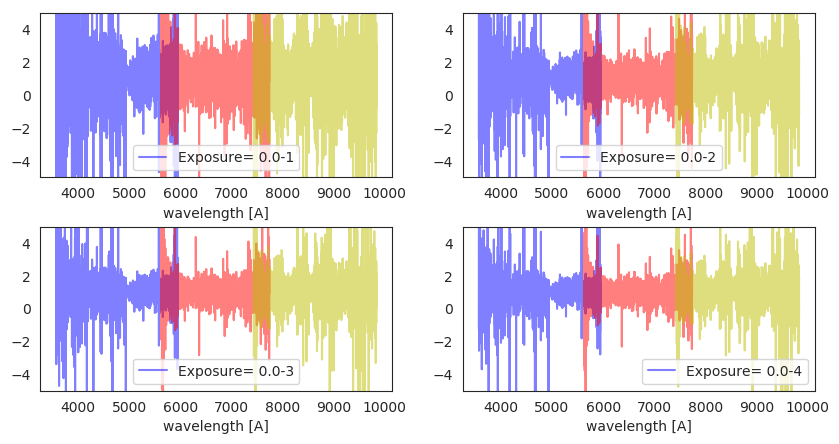

In [14]:
index = 4
plt.figure(figsize=(10,5),dpi=100)
for i in range(len(dump)):
    plt.subplot(221+i)
    exposure = dump[i].split('/')[-1]
    spectra= desispec.io.read_spectra(dump[i]+'/spectra.fits')
    plotspec_ratio(spectra,spectra_highexp,index,label='Exposure= '+exposure)
    #plt.xlim(3500,4300)
    plt.ylim(-5,5)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## look at the the other files that were produced: zbest.fits and truth.fits

### The "zbest" files are fake redshift catalogs for the simulated spectra. By default it is conformed with the true redshift but we can make it more realistic by adding some errors with the following flags:
### --sigma_kms_fog

### --gamma_kms_zfit

### --shift_kms_los

In [15]:
data_zbest = fitsio.FITS(path_highexp+'/zbest-16-0.fits')

In [17]:
data_zbest[1]


  file: /global/cscratch1/sd/tanting/mocks/quickquasar/1pix_test/0.0-1e5/zbest-16-0.fits
  extension: 1
  type: BINARY_TBL
  extname: ZBEST
  rows: 10
  column info:
    CHI2                f8  
    COEFF               f8  array[4]
    Z                   f8  
    ZERR                f8  
    ZWARN               i8  
    SPECTYPE           S96  
    SUBTYPE            S16  
    TARGETID            i8  
    DELTACHI2           f8  
    BRICKNAME           S8  

### The "Truth" files stores all the information regarding the templates used to construct the spectra, as well as the magnitude of the objects, true redshift, if the spectra has contaminats, etc.

In [18]:
data_truth = fitsio.FITS(path_highexp+'/truth-16-0.fits')

In [20]:
data_truth[2]


  file: /global/cscratch1/sd/tanting/mocks/quickquasar/1pix_test/0.0-1e5/truth-16-0.fits
  extension: 2
  type: BINARY_TBL
  extname: QSO_META
  rows: 10
  column info:
    TARGETID            i8  
    MABS_1450           f4  
    SLOPES              f4  array[5]
    EMLINES             f4  array[3,62]
    BAL_TEMPLATEID      i2  
    DLA                 b1  

## So far the spectra has no contaminants, so lets add some. We will start with DLA's

### There is two ways to add DLA's, one is at random redshifts and column density, and the other is by what is already stored in the transmission file. In this tutorial we will use the DLAs specified in the transmission file

In [21]:
exp='4'
contaminant='0.1DLA-'
outdir_dla=outdir +contaminant+exp
os.makedirs(outdir +contaminant+exp,exist_ok=True)
        
specfile = outdir +contaminant + exp +'/spectra.fits'
cmd ='quickquasars  -i {ifile} -o {outfile}  --zmin {zmin} --exptime {exptime}\
    --zbest --bbflux --add-LYB --desi-footprint \
    --nmax {nmax} --seed {seed} --dla file'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)

!$cmd

INFO:utils.py:79:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:quickquasars.py:817:main: Load SIMQSO model
INFO:quickquasars.py:825:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:210:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:215:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:223:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:302:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:306:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:lya_spectra.py:162:read_lya_skewers: Read DLAs from transmi

In [22]:
spectra_dla = desispec.io.read_spectra(outdir_dla +'/spectra.fits')
spectra_4exp = desispec.io.read_spectra(outdir + '0.0-4/spectra.fits')

In [23]:
truth_dla = fitsio.FITS(outdir_dla+'/truth-16-0.fits')

In [28]:
truth_dla#[3]['TARGETID'][:]


  file: /global/cscratch1/sd/tanting/mocks/quickquasar/1pix_test/0.1DLA-4/truth-16-0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      TRUTH
  2      BINARY_TBL      QSO_META
  3      BINARY_TBL      DLA_META

In [27]:
mask = np.isin(truth_dla[1]['TARGETID'][:],truth_dla[3]['TARGETID'][:])

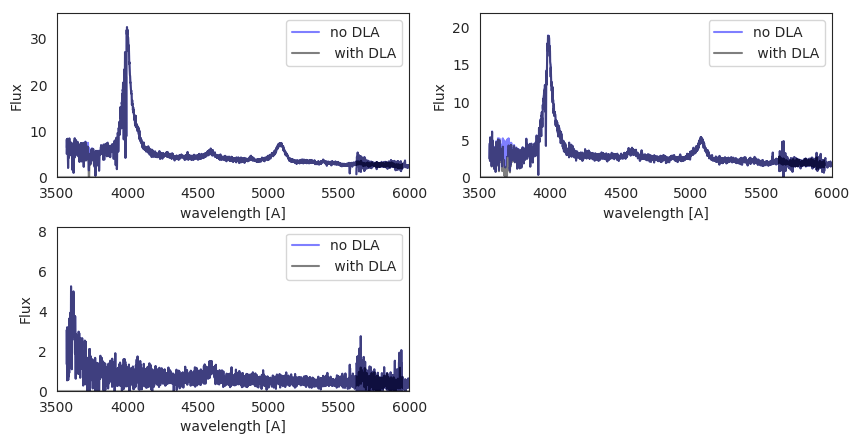

In [29]:
index = np.arange(nmax)
index = index[mask]
plt.figure(figsize=(10,5),dpi=100)
for i in range(3):
    plt.subplot(221+i)
    plotspec(spectra_4exp,index[i],color=['b','b','b'],label='no DLA')
    plotspec(spectra_dla,index[i],color=['k','k','k'],label=' with DLA')
    plt.xlim(3500,6000) #Make a zoom to see the differences
plt.subplots_adjust(hspace=0.3,wspace=.2)

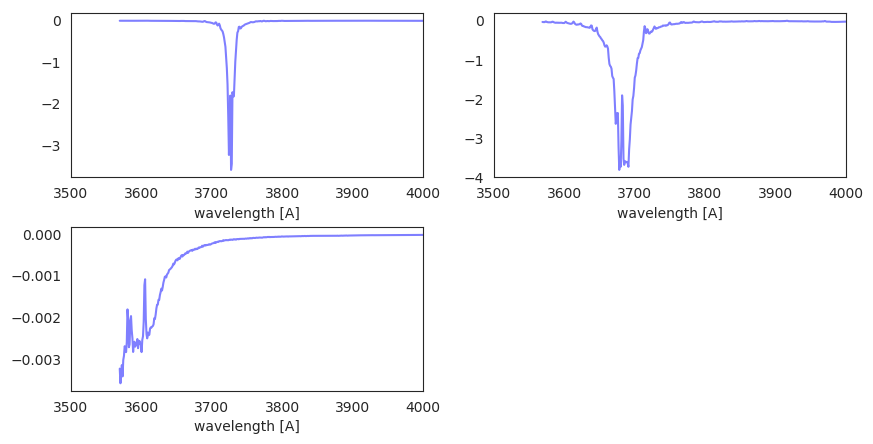

In [30]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(3):
    plt.subplot(221+i)
    plotspec_diff(spectra_dla,spectra_4exp,index[i])
    plt.xlim(3500,4000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## add BALs

In [31]:
exp='4'
contaminant='0.1BAL-'
outdir_bal=outdir +contaminant+exp
os.makedirs(outdir_bal,exist_ok=True)

specfile = outdir +contaminant + exp +'/spectra.fits'
cmd ='quickquasars  -i {ifile} -o {outfile}  --zmin {zmin} --exptime {exptime}\
    --zbest --bbflux --add-LYB --desi-footprint \
    --nmax {nmax} --seed {seed} --balprob 0.5'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
!$cmd

INFO:utils.py:79:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:quickquasars.py:817:main: Load SIMQSO model
INFO:quickquasars.py:825:main: Load DeCAM and WISE filters for target selection sim.
INFO:io.py:956:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bal_templates_v3.0.fits
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:210:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:215:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:223:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:302:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:306:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya

In [32]:
truth_bal = fitsio.FITS(outdir_bal+'/truth-16-0.fits')
mask = np.isin(truth_bal[1]['TARGETID'][:],truth_bal[3]['TARGETID'][:])
index = np.arange(nmax)
index = index[mask]

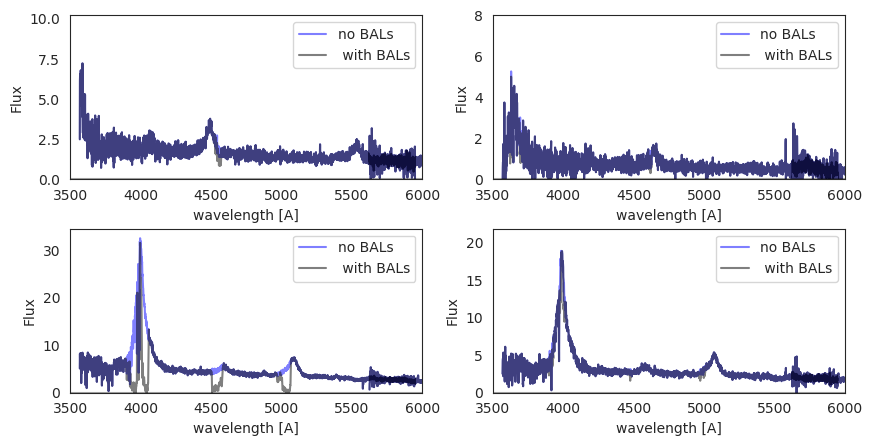

In [33]:
spectra_bal = desispec.io.read_spectra(outdir_bal +'/spectra.fits')
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec(spectra_4exp,index[i],color=['b','b','b'],label='no BALs')
    plotspec(spectra_bal,index[i],color=['k','k','k'],label=' with BALs')
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

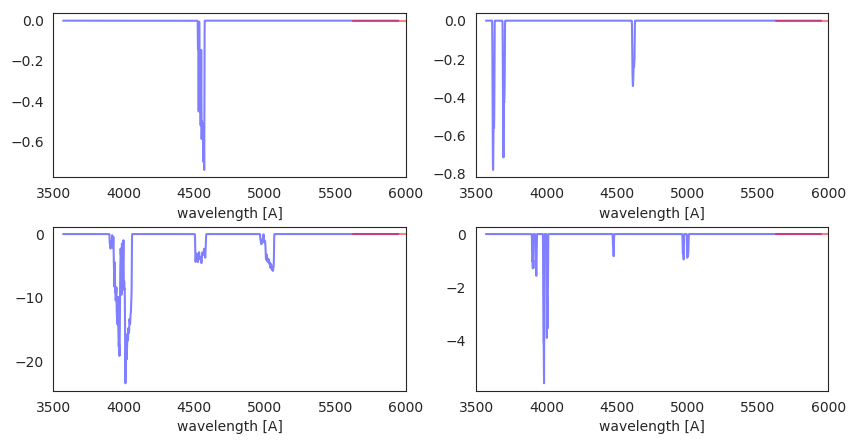

In [34]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec_diff(spectra_bal,spectra_4exp,index[i])
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## add metals

In [35]:
exp='4'
contaminant='0.1MET-'
outdir_metal=outdir +contaminant+exp
os.makedirs(outdir_metal,exist_ok=True)
specfile = outdir_metal+'/spectra.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
     --nmax {nmax} --seed {seed} --metals-from-file'.format(exptime=float(exp)*1000,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
!time $cmd

INFO:utils.py:79:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:quickquasars.py:817:main: Load SIMQSO model
INFO:quickquasars.py:825:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:210:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:215:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:223:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:302:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:306:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:lya_spectra.py:128:read_lya_skewers: Added F_Metals from tr

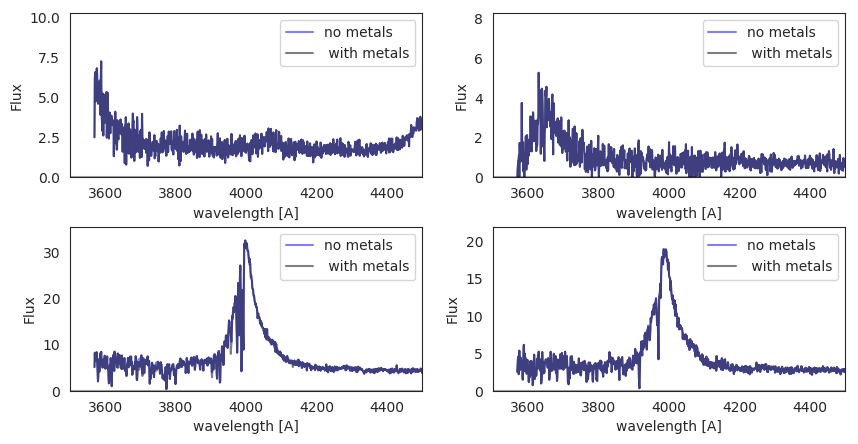

In [36]:

spectra_metals = desispec.io.read_spectra(outdir_metal +'/spectra.fits')
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec(spectra_4exp,i,color=['b','b','b'],label='no metals')
    plotspec(spectra_metals,i,color=['k','k','k'],label=' with metals')
    plt.xlim(3500,4500)
plt.subplots_adjust(hspace=0.3,wspace=.2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


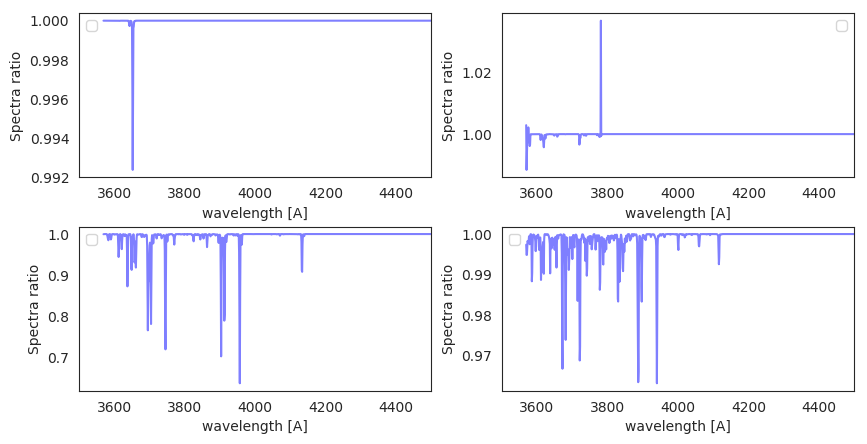

In [37]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec_ratio(spectra_metals,spectra_4exp,i)
    plt.ylabel('Spectra ratio')
    plt.xlim(3500,4500)
    #plt.ylim(0.8,1.01)
plt.subplots_adjust(hspace=0.3,wspace=.2)

## As stated at the begining, all this has been for a sinlge pixel but we can also run a quickquasar simulation for the full DESI footprint. For this, lets take a look and run to the script quickquasars.sh
## Now that we have a bigger quickquasar run, we can stack the outputs for each pixel into a sinlge catalog

In [40]:
mock_path = os.path.join(os.environ['SCRATCH'], 'mocks','quickquasar')
out_zcat = mock_path+'/tutorial-0.3-4/'

In [47]:
#os.makedirs(out_zcat, exist_ok=True)

In [49]:
!desi_zcatalog --help

usage: desi_zcatalog [-h] [-i INDIR] [-o OUTFILE] [-v]
                     [--match [MATCH [MATCH ...]]] [--fibermap]
                     [--spectra-scores]

optional arguments:
  -h, --help            show this help message and exit
  -i INDIR, --indir INDIR
                        input directory (default: None)
  -o OUTFILE, --outfile OUTFILE
                        output file (default: None)
  -v, --verbose         some flag (default: False)
  --match [MATCH [MATCH ...]]
                        match other tables (targets,truth...) (default: None)
  --fibermap            add some columns from fibermap stored in zbest files
                        (default: False)
  --spectra-scores      add some columns from scores stored in spectra files
                        (found in same directory as zbest file) (default:
                        False)


In [50]:
cmd='desi_zcatalog -i {ipath} -o {outfile} --fibermap'.format(ipath=out_zcat+'/spectra-16/',outfile=out_zcat+'zcat.fits')
if not os.path.isfile(out_zcat+'zcat.fits'):
    !time $cmd
else:
    print('zcat.fits already exist!')

INFO:desi_zcatalog:154:<module>: wrote /global/cscratch1/sd/tanting/mocks/quickquasar/tutorial-0.3-4/zcat.fits

real	1m6.020s
user	0m7.661s
sys	0m2.683s


In [51]:
zcat = fitsio.FITS(out_zcat+'/zcat.fits')
zcat


  file: /global/cscratch1/sd/tanting/mocks/quickquasar/tutorial-0.3-4//zcat.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      ZCATALOG

## To finish this part of the tutorial create some QA plots
## We can look at the redshift distribution of the zcatalog and compare to the expected one.

In [42]:
## Retrive the expected distribution as function of redshift and magnitude, and define some functions useful for plotting them. Some code was borrowed/adapted from https://github.com/dkirkby/ArgonneLymanAlpha/blob/master/notebooks/SampleProperties.ipynb

from astropy.table import Table,Column

def bin_index(bin_centers, low_edge):
    """Find the index of the bin with the specified low edge, where bins is an array of equally-spaced bin centers.
    """
    delta = bin_centers[1] - bin_centers[0]
    min_value = bin_centers[0] - 0.5 * delta
    index = int(round((low_edge - min_value) / delta))
    if abs((low_edge - min_value) / delta - index) > 1e-5:
        raise ValueError('low_edge = {} is not aligned with specified bins.'.format(low_edge))
    return index

def marginal_mag(magbin, zbin, nqso, z_min=0.):
    """Tabulate the marginal distribution of QSOs per sq.deg. per (g or r) magnitude bin with z > z_min.
    """
    cut_index = bin_index(zbin, z_min)
    return magbin, np.sum(nqso[:, cut_index:], axis=1)

def marginal_z(magbin, zbin, nqso, mag_max):
    """Tabulate the marginal distribution of QSOs per sq.deg. per redshift bin with mag < mag_max.
    """
    cut_index = bin_index(magbin, mag_max)
    return zbin, np.sum(nqso[:cut_index], axis=0)

qlf_file=os.getenv("DESIMODEL")+'/data/targets/nzr_qso.dat'
qlftab=Table.read(qlf_file,format='ascii',names=('z','r','dNdzdr'))
zbin=np.unique(qlftab['z'].data)
rbin=np.unique(qlftab['r'].data)
nz,nr=len(zbin),len(rbin)
assert len(qlftab) == nz*nr
nqso_=qlftab['dNdzdr'].data.reshape(nz,nr).transpose()

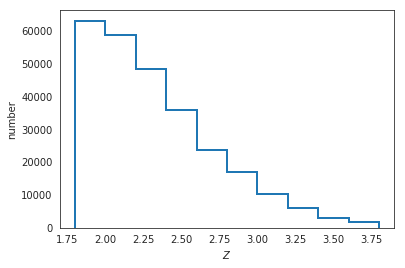

In [53]:
#Plot the redshift distribution from the z catalog
z=zcat[1]['Z'][:]
bins = np.arange(min(z),max(z),0.2)
nz_,_,_=plt.hist(z,bins=bins,histtype='step',linewidth=2.);
plt.xlabel(r'$Z$');
plt.ylabel('number');

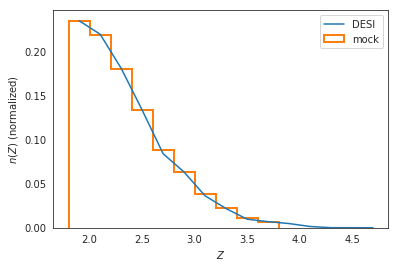

In [54]:
zz, nz = marginal_z(rbin, zbin, nqso_, mag_max=23)
plt.plot(zz[zz>1.8],nz[zz>1.8]/nz[zz>1.8].sum(),label='DESI')
plt.hist(z,bins=bins,weights=np.ones(len(z))/nz_.sum(),histtype='step',linewidth=2.,label='mock');
plt.xlabel(r'$Z$');
plt.ylabel(r'$n(Z)$ (normalized)');
plt.legend()

### Also we can look at the magnitude of each of the arms [b,r,z].
### As the zcatalog does not hace the magnitude information, we can calculate it from the flux as:
### $$ m = 22.5 - 2.5 \log_{10}(f) $$

In [55]:
def magnitud(flux):
    return 22.5-2.5*np.log10(flux)

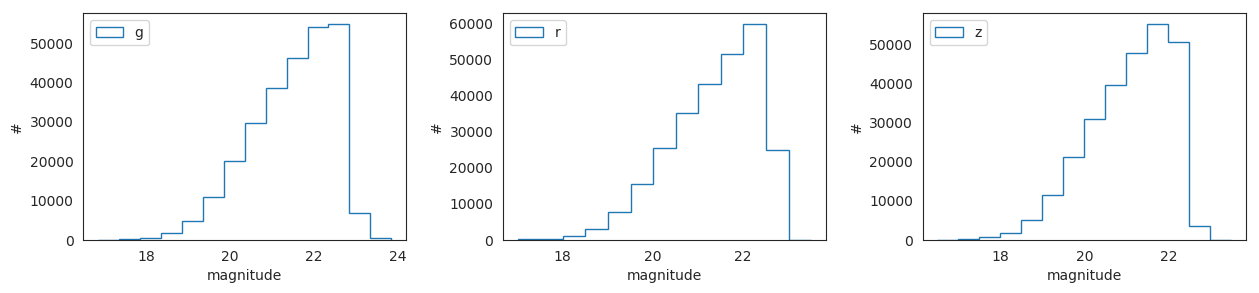

In [56]:
plt.figure(figsize=(15,3),dpi=100)

plt.subplot(131)
mag_b = magnitud(zcat[1]['FLUX_G'][:])
bins = np.arange(min(mag_b),max(mag_b),0.5)
plt.hist(mag_b,bins=bins,histtype='step',linewidth=1,label='g');
plt.xlabel('magnitude');
plt.ylabel('#');
plt.legend(loc='upper left')

plt.subplot(132)
mag_r = magnitud(zcat[1]['FLUX_R'][:])
bins = np.arange(min(mag_r),max(mag_r),0.5)
mr,binr,_=plt.hist(mag_r,bins=bins,histtype='step',linewidth=1,label='r');
plt.xlabel('magnitude');
plt.ylabel('#');
plt.legend(loc='upper left')

plt.subplot(133)
mag_z = magnitud(zcat[1]['FLUX_Z'][:])
bins = np.arange(min(mag_z),max(mag_z),0.5)
plt.hist(mag_z,bins=bins,histtype='step',linewidth=1,label='z');
plt.xlabel('magnitude');
plt.ylabel('#');
plt.legend(loc='upper left')


plt.subplots_adjust(wspace=.3)

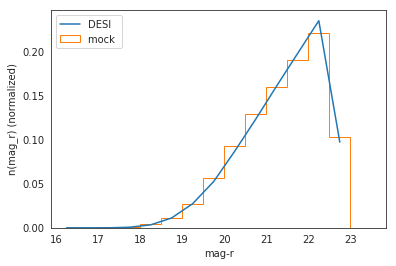

In [57]:
#Using the function above lets compare the magnitude r to the expected one. 

r, nr = marginal_mag(rbin, zbin, nqso_, z_min=1.8)
plt.plot(r,nr/nr.sum(),label='DESI')
plt.hist(mag_r,bins=bins,weights=np.ones(len(mag_r))/mr.sum(),histtype='step',linewidth=1,label='mock ');
plt.xlabel('mag-r')
plt.ylabel('n(mag_r) (normalized)')
plt.legend()

####  look at the distriubution of objects in the sky

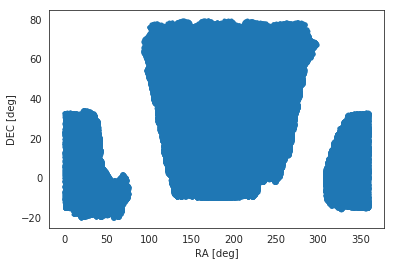

In [58]:
plt.scatter(zcat[1]['RA'][:],zcat[1]['DEC'][:],marker='.');
plt.xlabel('RA [deg]');
plt.ylabel('DEC [deg]');

### look at the object distributions for each pixels. For that we define functions to go from angles to pixels and back

In [59]:
def get_pix(ra,dec,nside=16):
    phi = ra*np.pi / 180.
    th = np.pi/2. - dec*np.pi/180.
    pix = healpy.ang2pix(nside,th,phi,nest=True)
    return pix

def pix2ang_deg(nside,pix,nest=True):
    pix_rad_dec,pix_rad_ra = healpy.pix2ang(nside,pix,nest=nest)
    pix_ra = pix_rad_ra * 180. / np.pi
    pix_dec = (np.pi/2.-pix_rad_dec)*180./np.pi
    return pix_ra, pix_dec

In [60]:
pix_zcat = get_pix(zcat[1]['RA'][:],zcat[1]['DEC'][:])

In [61]:
ra_zcat,dec_zcat = pix2ang_deg(16,np.unique(pix_zcat),nest=True)

### ploting the pixels, in the previous plot we plotted all the objects

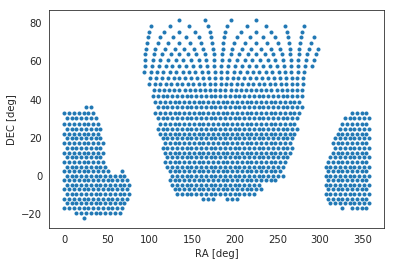

In [62]:
plt.scatter(ra_zcat,dec_zcat,marker='.');
plt.xlabel('RA [deg]');
plt.ylabel('DEC [deg]');

### plot the density of objects per pixels as well at the mean redshift in each pixel

In [63]:
def get_density(pix,nside):
    bincounts_pix = np.bincount(pix)
    unique_pix = np.unique(pix)
    area_pix = healpy.pixelfunc.nside2pixarea(nside, degrees=True)
    density = bincounts_pix[unique_pix]/area_pix
    return density

Text(0,0.5,'DEC [deg]')

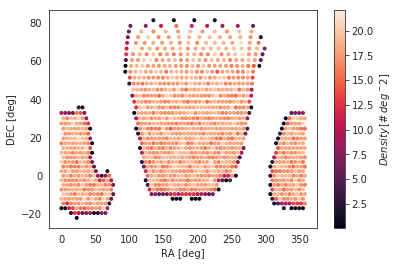

In [64]:
plot1 = plt.scatter(ra_zcat,dec_zcat,c=get_density(pix_zcat,16),marker='.')
cbar1 = plt.colorbar(plot1)
cbar1.set_label(r'$Density \, [\# \, deg^-2]$')
cbar1.update_ticks()
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Text(0,0.5,'DEC [deg]')

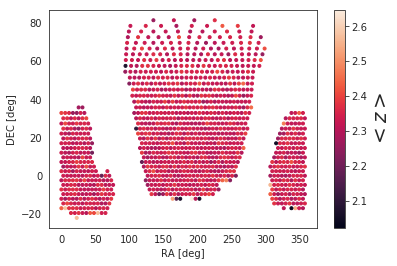

In [65]:
bincounts_pix = np.bincount(pix_zcat)
bincounts_z = np.bincount(pix_zcat,weights=zcat[1]['Z'][:])

z_pix_zcat = bincounts_z[np.unique(pix_zcat)]/bincounts_pix[np.unique(pix_zcat)]

plot1 = plt.scatter(ra_zcat,dec_zcat,c=z_pix_zcat,marker='.')
cbar1 = plt.colorbar(plot1)
cbar1.set_label(r'$<z>$',size=20)
cbar1.update_ticks()
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

### What's netxt?
We can run picca to calculate the flux over-densities as well as the correletions
- Here you can find a tutorial to run picca and do a BAO analysis: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/how_to_run_picca
We can also run a DLA finder and BAL finder
- DLA finder: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/DLAfinder
- BAL finder: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/BALfinder
As well feed the mock to redshift fitters:
- Redrock
- SQUEZE¶
- QuasarNet